## **Balancing a Pole on a Cart**
### 24S2 SC3000/CZ3005 Assignment 1
---
### Team Members
- Toh Jun Sheng
- Isaac Wong Jia Kai
- Tio Sher Min
---
### Contribution

#### Training the RL Agent (Q-Learning Agent)
- Discretize the continuous state space: Sher Min
- Code implementation of epsilon-greedy policy: Isaac
- Experiment with different bin sizes and hyperparameters: Jun Sheng
- Implement Q-table and training loop: Isaac, Jun Sheng, Sher Min

#### Task 1: Development of an RL Agent
- Sampling of random state from the CartPole Environment: Isaac, Jun Sheng, Sher Min

#### Task 2: Demonstrate the effectiveness of the RL agent
- Running 100 episodes of the RL agent: Isaac
- Plotting cumulative reward against episodes: Sher Min
- Write-up and markdown documentation: Jun Sheng

#### Task 3: Render one episode played by the developed RL agent
- Rendering video of the best episode of our trained RL agent: Isaac, Jun Sheng, Sher Min

#### Task 4: Format the Jupyter notebook
- Step-by-step markdown instructions and explanations: Jun Sheng, Sher Min
- Code cleanup and readability improvements: Isaac

#### Further investigation with Deep Q-Network (DQN)
- DQN model implementation and testing: Sher Min
- Evaluation of DQN performance: Jun Sheng, Isaac
---

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install moviepy > /dev/null 2>&1

zsh:1: no matches found: gym[classic_control]


## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [4]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [6]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: (array([-0.02422529,  0.00086176,  0.00615886,  0.03433837], dtype=float32), {})


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [7]:
observation, reward, terminated, truncated, info = env.step(0)
done = terminated or truncated

print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.02420805 -0.19434796  0.00684563  0.3289581 ]
Reward for this step: 1.0
Is this round done? False


c:\Users\Jun Sheng\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [8]:
observation, _ = env.reset()
cumulative_reward = 0
done = False

while not done:
    observation, reward, terminated, truncated, info = env.step(0)
    done = terminated or truncated
    cumulative_reward += reward

print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## <b>Training the RL Agent (Q-Learning Agent)</b>


In [9]:
# Initialize CartPole environment
env = gym.make("CartPole-v1")

#### Q-learning works with finite (discrete) state spaces, but the CartPole has a continuous state space, meaning there are infinitely many possible states. Since the agent can't store Q-values for an infinite number of states, we need to discretize the state space into bins.


In [10]:
# Discretize the continuous observation space into 25 evenly spaced bins
state_bins = [
    np.linspace(-4.8, 4.8, 25),     # Cart Position
    np.linspace(-5, 5, 25),         # Cart Velocity
    np.linspace(-0.418, 0.418, 25), # Pole Angle (in radians)
    np.linspace(-5, 5, 25)          # Pole Angular Velocity
]

# Function to discretize a continuous state
def get_discrete_state(state):
    discrete_state = []
    for s, bins in zip(state, state_bins):
        index = np.digitize(s, bins)
        index = min(max(index, 0), len(bins))  # Clip to valid range
        discrete_state.append(index)
    return tuple(discrete_state)

# Q-table initialization with zeros
q_table = np.zeros([len(b) + 1 for b in state_bins] + [env.action_space.n])

#### The observations from the current continuous state are mapped to their respective bins, forming a discrete state represented as a tuple. These discrete states define the Q-table, a multi-dimensional table that stores action-value estimates for each state-action pair.

In [11]:
# Check initial state
observation, _ = env.reset()
discrete_obs = get_discrete_state(observation)
print("Continuous state:", observation)
print("Discrete state:", tuple(int(x) for x in discrete_obs))

Continuous state: [ 0.01355716 -0.01053219  0.0056703  -0.02762008]
Discrete state: (13, 12, 13, 12)


#### Next, we define the hyperparameters that will be used by the Q-Learning agent

In [12]:
# Hyperparameters
alpha = 0.1            # Learning rate 
gamma = 0.99           # Discount factor 
epsilon = 1.0          # Initial exploration rate
epsilon_min = 0.05     # Min epsilon value
episodes = 10000       # Training episodes

#### Q-Learning Action Selection Process:
- During each step of an episode, a random number between 0 and 1 is generated and compared with the current epsilon value.
- If the random number is less than epsilon, the agent selects a random action (exploration).
- Otherwise, it selects the action with the highest Q-value for the current state from the Q-table (exploitation).


In [13]:
# Epsilon-greedy action selection
def epsilon_greedy_action(state, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(q_table[state])  # Exploit


def q_policy_agent(observation):
    discrete_state = get_discrete_state(observation)
    return np.argmax(q_table[discrete_state])

#### Now, we will proceed to train the agent over 10,000 episodes to populate the Q-table.

Episode 500, Reward: 21.952, Epsilon: 0.941
Episode 1000, Reward: 23.4, Epsilon: 0.881
Episode 1500, Reward: 27.412, Epsilon: 0.822
Episode 2000, Reward: 31.802, Epsilon: 0.762
Episode 2500, Reward: 39.236, Epsilon: 0.703
Episode 3000, Reward: 45.854, Epsilon: 0.644
Episode 3500, Reward: 59.294, Epsilon: 0.584
Episode 4000, Reward: 75.312, Epsilon: 0.525
Episode 4500, Reward: 95.716, Epsilon: 0.466
Episode 5000, Reward: 114.07, Epsilon: 0.406
Episode 5500, Reward: 121.526, Epsilon: 0.347
Episode 6000, Reward: 163.482, Epsilon: 0.287
Episode 6500, Reward: 182.764, Epsilon: 0.228
Episode 7000, Reward: 197.376, Epsilon: 0.169
Episode 7500, Reward: 241.262, Epsilon: 0.109
Episode 8000, Reward: 289.132, Epsilon: 0.050
Episode 8500, Reward: 347.78, Epsilon: 0.050
Episode 9000, Reward: 348.912, Epsilon: 0.050
Episode 9500, Reward: 236.732, Epsilon: 0.050


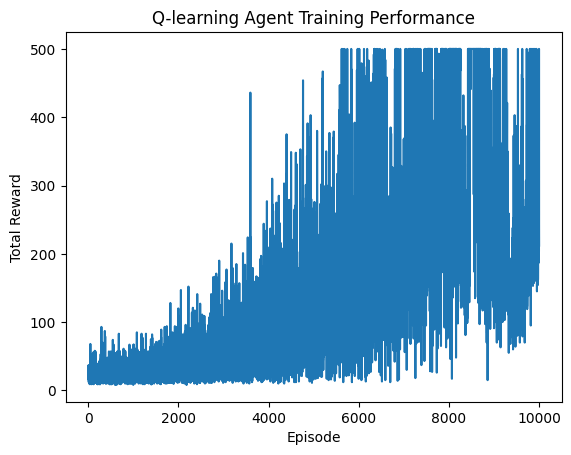

In [14]:
# Training
rewards = []
total_mean_reward = 0
epsilon_decay = (epsilon-epsilon_min)/(episodes*0.8)

for episode in range(episodes):
    state = get_discrete_state(env.reset()[0])
    done = False
    total_reward = 0

    while not done:
        action = epsilon_greedy_action(state, epsilon)

        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = get_discrete_state(next_obs)

        # Q-learning update rule
        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + gamma * q_table[next_state][best_next_action]
        td_error = td_target - q_table[state][action]
        q_table[state][action] += alpha * td_error

        state = next_state
        total_reward += reward

    rewards.append(total_reward)
    total_mean_reward += total_reward

    # Epsilon decay (linear decay)
    if epsilon > epsilon_min:
        epsilon -= epsilon_decay

    # Print progress
    if episode % 500 == 0 and episode != 0:
        print(f"Episode {episode}, Reward: {total_mean_reward/500}, Epsilon: {epsilon:.3f}")
        total_mean_reward = 0

# Plotting cumulative reward
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-learning Agent Training Performance")
plt.show()

#### By allowing epsilon to decay linearly so that the minimum value is reached after around 8000 episodes, we can observe the epsilon-greedy process at work — gradually shifting from more exploration to more exploitation.

#### Since epsilon starts at 1 and decreases over time, the agent explores more in the early episodes (frequently choosing random actions). As epsilon gets smaller, the agent shifts toward exploitation (frequently choosing the best-known actions). It stops decreasing at 0.05, ensuring the agent never stops exploring completely.


## <b>Task 1: Development of an RL agent</b> 

#### We sampled a random observation state from the cart pole environment. In this particular observation state (continous and discrete), we see that the best action found by the agent after training is 0 (left).

In [15]:
# === Task 1 ===
observation = env.reset()[0]
discrete_obs = get_discrete_state(observation) 
action = q_policy_agent(observation)

print("Continuous state:", observation)
print("Discrete state:", tuple(int(x) for x in discrete_obs)) 
print("Chosen action:", action)

Continuous state: [-0.02262692  0.03187404 -0.04975154  0.01995177]
Discrete state: (12, 13, 11, 13)
Chosen action: 0


## <b>Task 2: Demonstrate the effectiveness of the RL agent</b> 

#### In this task, we set `epsilon = 0.0` to completely disable exploration, ensuring the agent always selects the best-known action based on the Q-table. We run for 100 episodes (reset the environment at the beginning of each episode) and plot the cumulative reward against all episodes. Each episode is also run with a fixed seed to make results reproducible. From our result, the average reward over the 100 episodes is larger than 195.

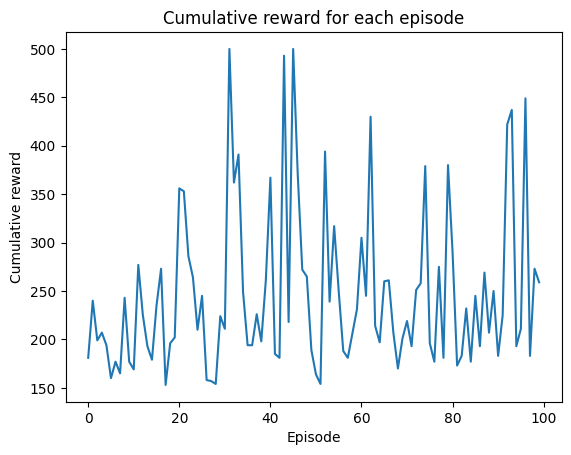

Average cumulative reward: 246.56
Is my agent good enough? True


In [16]:
# === Task 2 ===

epsilon = 0.0
episode_results = []
best_episode_index = -1  #Stores best episode index
best_reward = 0

for episode in range(100):
    obs = env.reset(seed=episode)[0]  # fixed seed = reproducible episode
    state = get_discrete_state(obs)
    done = False
    total_reward = 0

    while not done:
        action = epsilon_greedy_action(state, epsilon)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = get_discrete_state(next_obs)
        total_reward += reward

    episode_results.append(total_reward)

    if total_reward > best_reward:
        best_reward = total_reward
        best_episode_index = episode

env.close()

# Plot cumulative rewards
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

# Print results
print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)


## <b>Task 3: Render one episode played by the developed RL agent</b> 

#### We visualise the agent's performance by recording the episode where it achieved the highest reward (from Task 2). Using a fixed seed guarantees that the **exact same episode** is recorded and played back for demonstration.

In [17]:
# === Task 3 ===

# Print best episode
print("Best episode index:", best_episode_index)
print("Best reward:", best_reward)

# Create a new environment that records the best episode
env = RecordVideo(
    gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="video",
    episode_trigger=lambda e: True
)

# Reset with the same seed used in Task 2
observation = env.reset(seed=best_episode_index)[0]
done = False

while not done:
    action = q_policy_agent(observation)
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

# Display recorded video
show_video()


Best episode index: 31
Best reward: 500.0


c:\Users\Jun Sheng\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building video c:\Users\Jun Sheng\OneDrive\Desktop\SC3000-AI-1\video\rl-video-episode-0.mp4.
MoviePy - Writing video c:\Users\Jun Sheng\OneDrive\Desktop\SC3000-AI-1\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\Jun Sheng\OneDrive\Desktop\SC3000-AI-1\video\rl-video-episode-0.mp4


## <b>Further investigation with Deep Q-Network (DQN)</b>

#### Let's also explore the difference between Q-learning and DQN in solving the CartPole problem. We will demonstrate the effectiveness of DQN agent by plotting the cumulative rewards and displaying the average reward over 100 episodes. 

In [4]:
# Install dependencies
!pip install "shimmy>=2.0"
!pip install stable-baselines3
from stable_baselines3 import DQN

In [5]:
# Initialize environment
env = gym.make("CartPole-v1")

# DQN with default parameters
dqn_model = DQN("MlpPolicy", env, seed = 42, verbose=1)

# Training
def train_dqn_model(model, total_timesteps=1000000):
    print("Training DQN model...")
    model.learn(total_timesteps=total_timesteps)
    model.save("dqn_cartpole")
    print("DQN model trained and saved.")
    return model

dqn_model = train_dqn_model(dqn_model, total_timesteps=1000000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Training DQN model...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23       |
|    ep_rew_mean      | 23       |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 15139    |
|    time_elapsed     | 0        |
|    total_timesteps  | 92       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.9     |
|    ep_rew_mean      | 24.9     |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1745     |
|    time_elapsed     | 0        |
|    total_timesteps  | 199      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 24       |
----------------------------------
----------------------------------
| rollout/            |          

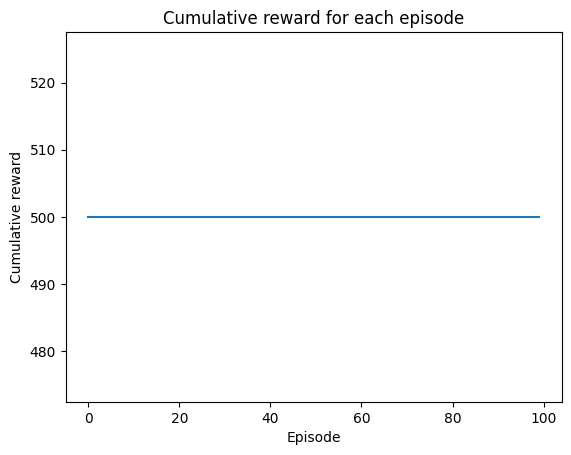

Average cumulative reward: 500.0
Is my agent good enough? True


In [6]:
episode_results = []

for episode in range(100):
    obs = env.reset(seed=episode)[0]
    done = False
    total_reward = 0

    while not done:
        action, _ = dqn_model.predict(obs, deterministic = True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    episode_results.append(total_reward)

env.close()

# === Plot rewards ===
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

# === Print result ===
print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

#### As we can see from the results above, DQN achieves a higher average cumulative reward and demonstrates more stable performance compared to Q-learning. While Q-learning requires discretizing CartPole’s continuous state space into finite bins, DQN can operate directly on continuous state spaces using neural networks, making it more suitable for environments like CartPole.